In [28]:
import pandas as pd

data= pd.read_csv("kidney_disease - kidney_disease.csv")
df=data.copy()

In [29]:
important_cols = ['sc', 'bu', 'hemo', 'al', 'sg', 'bgr', 'pcv', 'htn', 'dm', 'age','classification']
df_imp=df[important_cols]

In [30]:
df_imp=df_imp.rename(columns={
    'sc': 'serum_creatinine',
    'bu': 'blood_urea',
    'hemo': 'hemoglobin',
    'al': 'albumin',
    'sg': 'specific_gravity',
    'bgr': 'blood_glucose_random',
    'pcv': 'packed_cell_volume',
    'htn': 'hypertension',
    'dm': 'diabetes_mellitus',
    'age': 'age'
})

In [31]:
df_imp['packed_cell_volume'] = pd.to_numeric(df_imp['packed_cell_volume'], errors='coerce')    

In [32]:
num_cols = df_imp.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_imp.select_dtypes(include=['object', 'category']).columns

In [6]:
num_cols

Index(['serum_creatinine', 'blood_urea', 'hemoglobin', 'albumin',
       'specific_gravity', 'blood_glucose_random', 'packed_cell_volume',
       'age'],
      dtype='object')

In [7]:
cat_cols

Index(['hypertension', 'diabetes_mellitus', 'classification'], dtype='object')

In [26]:
df_imp[num_cols] = df_imp[num_cols].fillna(df_imp[num_cols].median())

In [33]:
for col in cat_cols:
    df_imp[col]=df_imp[col].fillna(df_imp[col].mode()[0])

In [10]:
df_imp['classification']

0         ckd
1         ckd
2         ckd
3         ckd
4         ckd
        ...  
395    notckd
396    notckd
397    notckd
398    notckd
399    notckd
Name: classification, Length: 400, dtype: object

In [34]:
# Convert text to numbers
for col in df_imp.columns:
    if df_imp[col].dtype == 'object':
        df_imp[col] = df_imp[col].astype('category').cat.codes

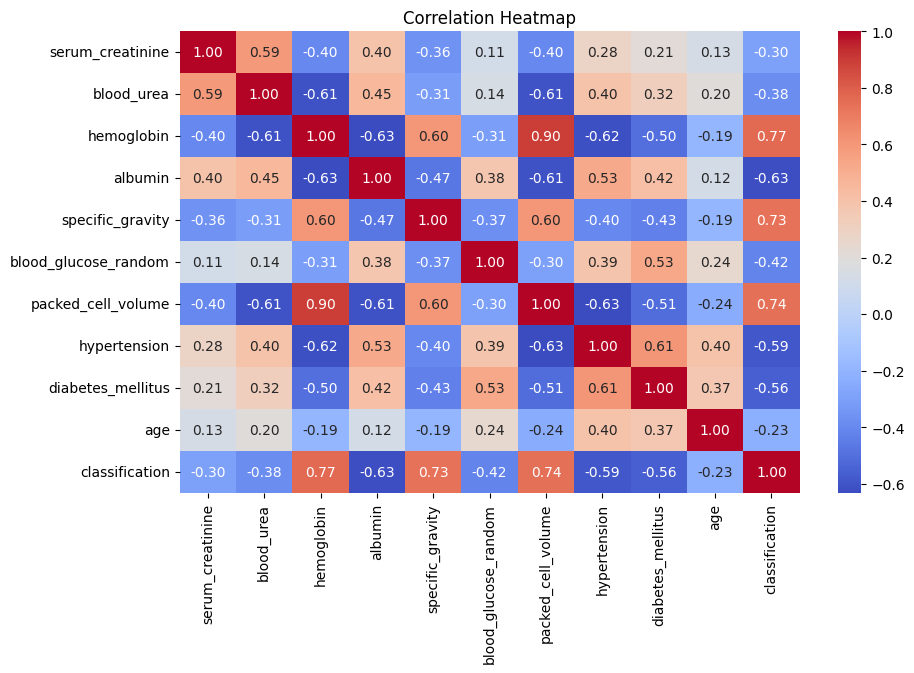

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.heatmap(df_imp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

   




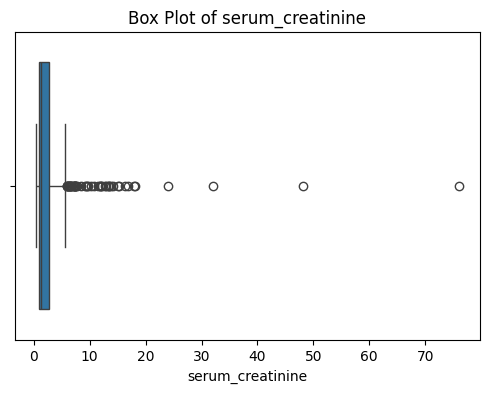

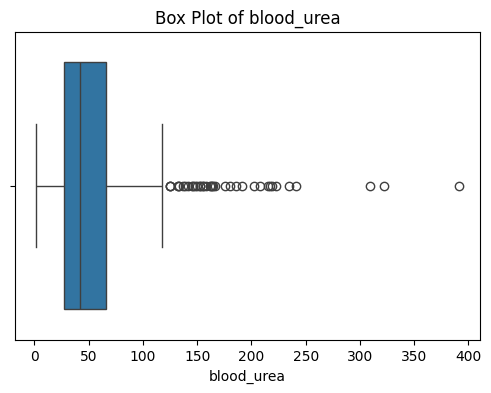

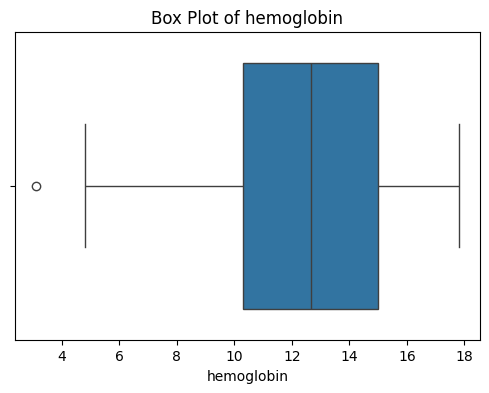

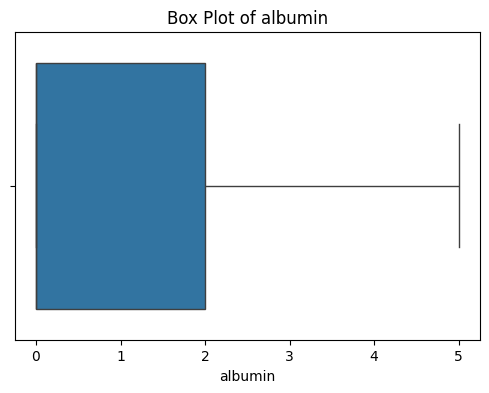

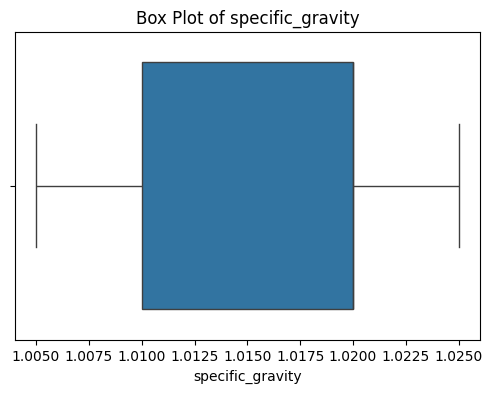

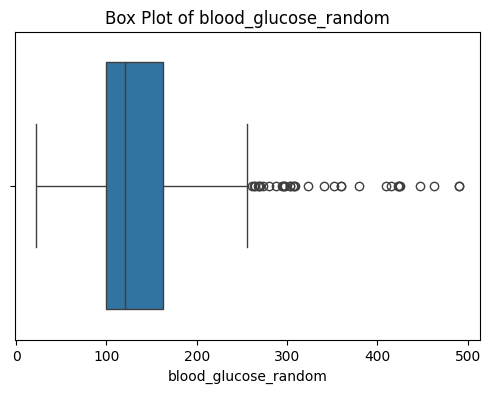

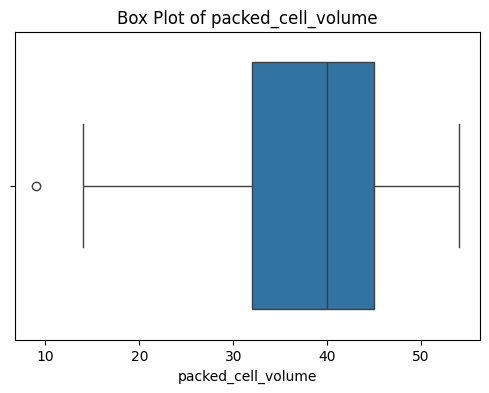

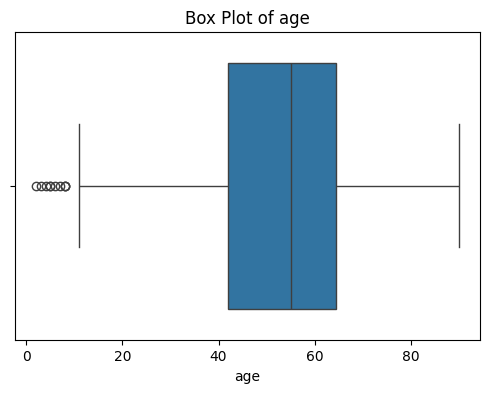

In [36]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_imp[col])
    plt.title(f"Box Plot of {col}")
    plt.show()

In [12]:
df_imp['classification']

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: classification, Length: 400, dtype: int8

In [13]:
df_imp.shape

(400, 11)

In [14]:

df_kidney= df_imp.copy()


for col in df_kidney:
    Q1 = df_kidney[col].quantile(0.25)
    Q3 = df_kidney[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

 
    df_kidney[col] = df_kidney[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers capped. New shape:", df_kidney.shape)


Outliers capped. New shape: (400, 11)


In [15]:
df_kidney['classification']

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: classification, Length: 400, dtype: int8

In [16]:
df_kidney.columns

Index(['serum_creatinine', 'blood_urea', 'hemoglobin', 'albumin',
       'specific_gravity', 'blood_glucose_random', 'packed_cell_volume',
       'hypertension', 'diabetes_mellitus', 'age', 'classification'],
      dtype='object')

In [17]:
x=df_kidney.drop(['classification'],axis=1)
y=df_kidney['classification']


In [18]:
x

,serum_creatinine,blood_urea,hemoglobin,albumin,specific_gravity,blood_glucose_random,packed_cell_volume,hypertension,diabetes_mellitus,age
0,1.2,36.0,15.4,1.0,1.0200,121.0,44.0,1,1,48.0
1,0.8,18.0,11.3,4.0,1.0200,121.0,38.0,0,0,9.0
2,1.8,53.0,9.6,2.0,1.0100,223.5,31.0,0,1,62.0
3,3.8,56.0,11.2,4.0,1.0075,117.0,32.0,1,0,48.0
4,1.4,26.0,11.6,2.0,1.0100,106.0,35.0,0,0,51.0
...,...,...,...,...,...,...,...,...,...,...
395,0.5,49.0,15.7,0.0,1.0200,140.0,47.0,0,0,55.0
396,1.2,31.0,16.5,0.0,1.0250,75.0,54.0,0,0,42.0
397,0.6,26.0,15.8,0.0,1.0200,100.0,49.0,0,0,12.0
398,1.0,50.0,14.2,0.0,1.0250,114.0,51.0,0,0,17.0


In [19]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: classification, Length: 400, dtype: int8

In [20]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)

In [21]:
import numpy as np
import pickle


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class_counts = np.bincount(y.astype(int))
imbalance_ratio = max(class_counts) / min(class_counts)

print("Class counts:", dict(enumerate(class_counts)))
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    main_metric = "F1"
    print("Dataset is imbalanced → using F1-score as main metric")
else:
    main_metric = "Accuracy"
    print("Dataset is balanced → using Accuracy as main metric")

# Models to test
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

results = []

trained_models = {}  # Store trained model objects


# Train & evaluate each model
for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)

    trained_models[name] = model  # Store the trained model

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(ytest, y_pred),
        "Precision": precision_score(ytest, y_pred, average="weighted"),
        "Recall": recall_score(ytest, y_pred, average="weighted"),
        "F1": f1_score(ytest, y_pred, average="weighted")
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Sort by chosen main metric
df_results = df_results.sort_values(by=main_metric, ascending=False)
print("\n Model Performance Comparison:")
print(df_results)

# Best model
# Best model
best_model_name = df_results.iloc[0]["Model"]
best_model = trained_models[best_model_name]
print(f"\n Best model based on {main_metric}: {best_model_name}")


# Save the best model to a pickle file
with open("best_model_kidney.pkl", "wb") as f:
    pickle.dump(best_model, f)
print(f" Best model saved as 'best_model.pkl'")


Class counts: {0: 250, 1: 150}
Imbalance ratio: 1.67
Dataset is imbalanced → using F1-score as main metric

 Model Performance Comparison:
                    Model  Accuracy  Precision  Recall        F1
3  RandomForestClassifier    1.0000   1.000000  1.0000  1.000000
0  DecisionTreeClassifier    0.9875   0.987931  0.9875  0.987549
1      LogisticRegression    0.9875   0.987736  0.9875  0.987446
2    KNeighborsClassifier    0.9500   0.956250  0.9500  0.950667

 Best model based on F1: RandomForestClassifier
 Best model saved as 'best_model.pkl'


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns



sns.heatmap(F1-score,annot=True,cmap='red',fmt='g')

plt.xlabel['']
plt.ylabel['']
plt.title['']
plt.show()

NameError: name 'F1' is not defined